In [2]:
import cv2
import dlib
import time
import threading
import math
import numpy as np

from IPython.display import display, Image, clear_output
from io import BytesIO
import PIL
%matplotlib inline

In [3]:
video = cv2.VideoCapture("Forklift_video.mp4")

In [5]:
ssd = cv2.dnn.readNetFromCaffe("./MobileNetSSD_deploy.prototxt","./MobileNetSSD_deploy.caffemodel")

In [6]:
def estimateSpeed(location1, location2,ppm=8.8,fps=24):
    d_pixels = math.sqrt(math.pow(location2[0] - location1[0], 2) + math.pow(location2[1] - location1[1], 2))
    d_meters = d_pixels / ppm
    fps = 18
    speed = d_meters * fps * 3.6
    return speed

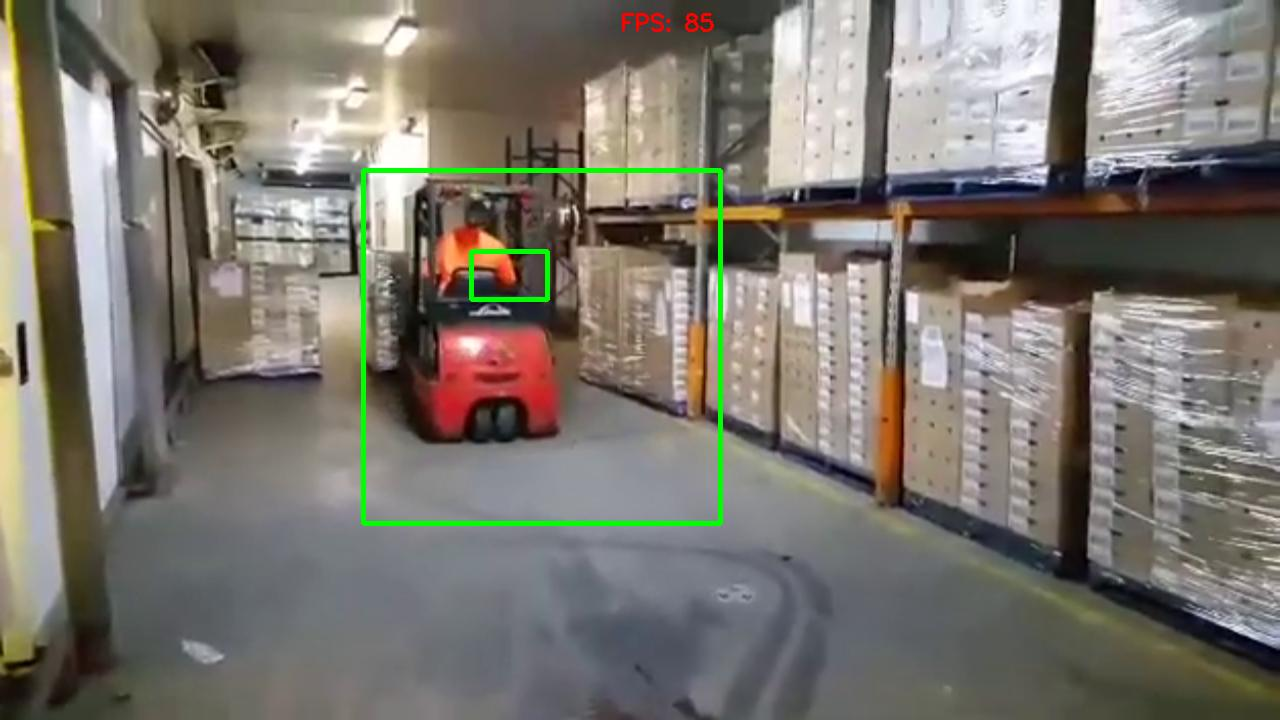

In [ ]:
def trackMultipleObjects(WIDTH = 1280, HEIGHT = 720):
    rectangleColor = (0, 255, 0)
    frameCounter = 0
    currentForkliftID = 0
    fps = 0

    forkliftTracker = {}
    forkliftNumbers = {}
    forkliftLocation1 = {}
    forkliftLocation2 = {}
    tracker_info = {}
    speed = [None] * 1000
    
    while True:
        start_time = time.time()
        rc, image = video.read()
        if type(image) == type(None):
            break

        image = cv2.resize(image, (WIDTH, HEIGHT))
        resultImage = image.copy()

        frameCounter = frameCounter + 1

        forkliftIDtoDelete = []

        for forkliftID in forkliftTracker.keys():
            trackingQuality = forkliftTracker[forkliftID].update(image)

            if trackingQuality < 7:
                forkliftIDtoDelete.append(forkliftID)

        for forkliftID in forkliftIDtoDelete:
            print ('Removing forkliftID ' + str(forkliftID) + ' from list of trackers.')
            forkliftTracker.pop(forkliftID, None)
            forkliftLocation1.pop(forkliftID, None)
            forkliftLocation2.pop(forkliftID, None)

        if not (frameCounter % 10):
            blob = cv2.dnn.blobFromImage(cv2.resize(image,(300,300)),0.007843,(400,400),(127.5,127.5,127.5),False)
            ssd.setInput(blob)
            detection_ssd = ssd.forward()
            forklifts=[]

            for i in range(detection_ssd.shape[2]):
                confidence=detection_ssd[0,0,i,2]
                if confidence > 0.2:
                    class_id = int(detection_ssd[0,0,i,1])
                    if class_id in [6,7]:
                        xLeftBottom = int(detection_ssd[0, 0, i, 3] * 300) 
                        yLeftBottom = int(detection_ssd[0, 0, i, 4] * 300)
                        xRightTop   = int(detection_ssd[0, 0, i, 5] * 300)
                        yRightTop   = int(detection_ssd[0, 0, i, 6] * 300)

                        heightFactor = image.shape[0]/300.0  
                        widthFactor = image.shape[1]/300.0 

                        xLeftBottom = int(widthFactor * xLeftBottom) 
                        yLeftBottom = int(heightFactor * yLeftBottom)
                        xRightTop   = int(widthFactor * xRightTop)
                        yRightTop   = int(heightFactor * yRightTop)
                        class_name = 'forklift' if class_id == 7 else 'other vehicle'

                        forklifts.append([xLeftBottom,yLeftBottom,xRightTop-xLeftBottom,yRightTop-yLeftBottom,confidence,class_name])  

            for (_x, _y, _w, _h, _c, _n) in forklifts:
                x = int(_x)
                y = int(_y)
                w = int(_w)
                h = int(_h)
                conf = str('%.3f' %_c)
                det_class = str(_n)

                x_bar = x + 0.5 * w
                y_bar = y + 0.5 * h
                
                matchForkliftID = None

                for forkliftID in forkliftTracker.keys():
                    trackedPosition = forkliftTracker[forkliftID].get_position()
                        
                    t_x = int(trackedPosition.left())
                    t_y = int(trackedPosition.top())
                    t_w = int(trackedPosition.width())
                    t_h = int(trackedPosition.height())
                        
                    t_x_bar = t_x + 0.5 * t_w
                    t_y_bar = t_y + 0.5 * t_h
                    
                    if ((t_x <= x_bar <= (t_x + t_w)) and (t_y <= y_bar <= (t_y + t_h)) and (x <= t_x_bar <= (x + w)) and (y <= t_y_bar <= (y + h))):
                        matchForkliftID = forkliftID
                    
                if matchForkliftID is None:
                    print ('Creating new tracker ' + str(currentForkliftID))
                        
                    tracker = dlib.correlation_tracker()
                    tracker.start_track(image, dlib.rectangle(x, y, x + w, y + h))
                        
                    forkliftTracker[currentForkliftID] = tracker
                    forkliftLocation1[currentForkliftID] = [x, y, w, h]
                    tracker_info[currentForkliftID] = [det_class,conf]
                    currentForkliftID = currentForkliftID + 1


        for forkliftID in forkliftTracker.keys():
            trackedPosition = forkliftTracker[forkliftID].get_position()
                    
            t_x = int(trackedPosition.left())
            t_y = int(trackedPosition.top())
            t_w = int(trackedPosition.width())
            t_h = int(trackedPosition.height())
                
            cv2.rectangle(resultImage, (t_x, t_y), (t_x + t_w, t_y + t_h), rectangleColor, 4)
                
            forkliftLocation2[forkliftID] = [t_x, t_y, t_w, t_h]
            
        end_time = time.time()
            
        if not (end_time == start_time):
            fps = 1.0/(end_time - start_time)
            
        cv2.putText(resultImage, 'FPS: ' + str(int(fps)), (620, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)


        for i in forkliftLocation1.keys():
            if frameCounter % 1 == 0:
                [x1, y1, w1, h1] = forkliftLocation1[i]
                [x2, y2, w2, h2] = forkliftLocation2[i]

                forkliftLocation1[i] = [x2, y2, w2, h2]

                if [x1, y1, w1, h1] != [x2, y2, w2, h2]:
                    if (speed[i] == None or speed[i] == 0) and y1 >= 275 and y1 <= 285:
                        speed[i] = estimateSpeed([x1, y1, w1, h1], [x2, y2, w2, h2])

                    if speed[i] != None and y1 >= 180 and h1 > 100 and h2 > 100:
                        cv2.putText(resultImage, tracker_info[i][0] +"("+tracker_info[i][1]+")" + str(i) + ": "+str(int(speed[i])) + " km/hr", (int(x1 + w1/2), int(y1-5)),cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2)

        frame=cv2.cvtColor(resultImage, cv2.COLOR_BGR2RGB) 
        f = BytesIO()
        PIL.Image.fromarray(frame).save(f,'jpeg')
        clear_output(wait=True)
        display(Image(f.getvalue()))

trackMultipleObjects()
